# Recursive neural network model on synthesized time series

* Use sequence RNN models for forecasting synthesized time sires.
* Comparison of simple RNN vs LSTM
* Windowed time siries for training.
* Dynamic tuning of learning rate with callbacks.
* Lambda layers for pre- and post-processing of data within NN.

## Create time series with trend + seasonality + noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.sin(season_time * 10 * np.pi),
                    1 / np.exp(10 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

* Synthesized time sires with trend, seasonality, and noise

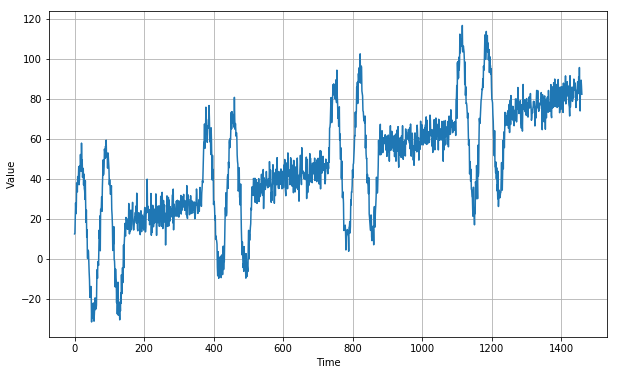

In [2]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series with trend and seasonality
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

* Split data to train and validation sets

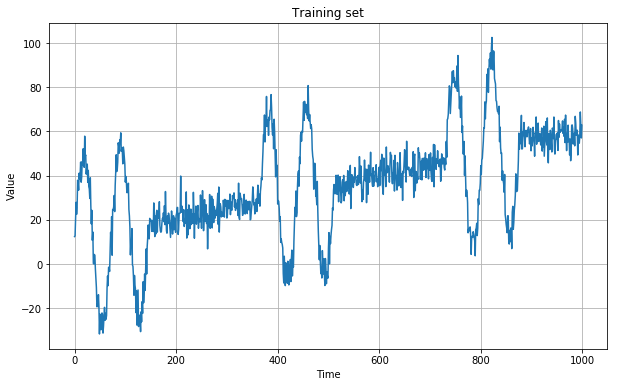

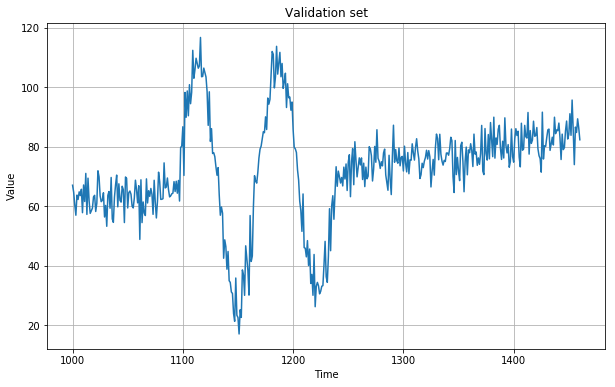

In [3]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.title("Training set")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.title("Validation set")
plt.show()

## Windowed time series

* Time windows generator (with tf.data.Dataset) for creating input datasets for training neural network.

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Create tensorflow dataset from time serie array
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Create windowed (nested) dataset, "+ 1" for the label data
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # Flattening out the windowed dataset with a given window size
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Shuffling the dataset & separating dataset into inputs and labels
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    # Batch the input-label dataset with a given batch size
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Simple RNN

* Here, we use simple RNN.
* Unlike DNN, RNN consider the order of input, i.e., latest data has larger influence on the prediction than the old data, which is ideal for time series forecasting.

In [17]:
# Create input dataset with training dataset
window_size = 20
batch_size = 30
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

* First check the optimal learning rate with dynamic adjustment of lr using call backs
* Lambda layers are used to pre- and post-processing of the data
* Hubber loss function is used instead of mse. Hubber loss function is less sensitive to the large noise.

In [24]:
model1 = tf.keras.models.Sequential([
    # dataset created by windowed_dataset function is 2 dimension, but RNN need 3d input. 
    # "-1" means the last dimension
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    # 2 simple RNN layers
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    # Output layer
    tf.keras.layers.Dense(1),
    # Rescale the results
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# SGD optimizer with an initial learning rate
optimizer1 = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Huber loss function which is less sensitive to the largely fluctuated noise than mse
model1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer1, metrics=["mae"])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, None, 1)           0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 32)          1088      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
_________________________________________________________________
lambda_10 (Lambda)           (None, 1)                 0         
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


* Dynamic tuning of learning rate with callbacks is used to choose an appropriate learning rate for training DNN.

In [26]:
# Construct learning rate scheduler based on the number of epoch
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Training
history1 = model1.fit(dataset,epochs=100,callbacks=[lr_schedule], verbose=0)

* Plotting the loss function as a function of learning rate
* Optimal learning rate < $10^{-5}$

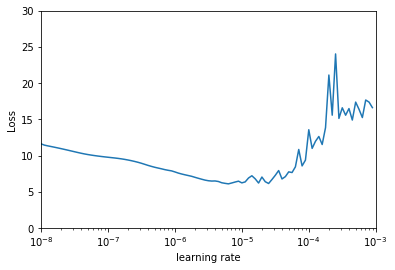

In [28]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history1.history["loss"])
plt.axis([1e-8, 1e-3, 0, 30])
plt.xlabel("learning rate")
plt.ylabel("Loss")
plt.show()

* Restraining the model with an appropriate learning rate

In [29]:
model2 = tf.keras.models.Sequential([
    # dataset created by windowed_dataset function is 2 dimension, but RNN need 3d input. 
    # "-1" means the last dimension
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    # 2 simple RNN layers
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    # Output layer
    tf.keras.layers.Dense(1),
    # Rescale the results
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# SGD optimizer with an initial learning rate
optimizer2 = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)

# Huber loss function which is less sensitive to the largely fluctuated noise than mse
model2.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer2, metrics=["mae"])

# Training
history2 = model2.fit(dataset,epochs=300, verbose=0)

* Plotting the training history

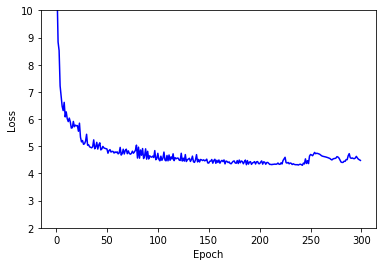

In [33]:
loss1 = history2.history['loss']
epochs1 = range(len(loss1))
plt.plot(epochs1, loss1, 'b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([2,10])
plt.show()

* Plotting the prediction with simple RNN model
* Threr is a large discrepancy in the high peaks. Also there is a shift in the part going up with a similar slope.

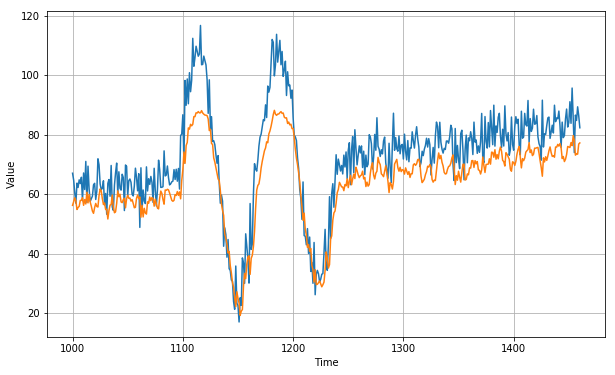

In [34]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model2.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
#print(np.array(forecast).shape)
results1 = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results1)
plt.show()

* Mean squre error and mean absolute error of the simple RNN model

In [55]:
print("Simple RNN MSE = ", keras.metrics.mean_squared_error(x_valid, results1).numpy())
print("Simple RNN MAE = ", keras.metrics.mean_absolute_error(x_valid, results1).numpy())

Simple RNN MSE =  110.88438
Simple RNN MAE =  8.676702


## Long short-term memory model

* Here we try to train a more complex LSTM model
* LSTM model can memorize long-term trend of the time series by passing the cell states.
* Again, optimal learning rate is first checked using learning rate schedule.

In [46]:
# LSTM model with 2 LSTM layers
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Optimizer with initial learning rate
optimizer3 = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model3.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer3)
model3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_23 (Lambda)           (None, None, 1)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 32)          4352      
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
_________________________________________________________________
lambda_24 (Lambda)           (None, 1)                 0         
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Construct learning rate scheduler based on the number of epoch
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Training with callbacks
history3 = model3.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

* Plot the loss as a function of learning rate (lr is a function of the number of epoch)
* As it can be seen, the loss increases rapidly as the learning rate becomees too large. Learning rate < $10^{-5}$ should be used

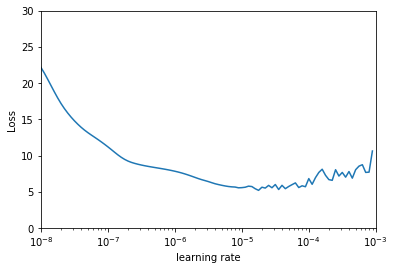

In [49]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history3.history["loss"])
plt.axis([1e-8, 1e-3, 0, 30])
plt.xlabel("learning rate")
plt.ylabel("Loss")
plt.show()

* Traing the model with appropriate learning rage.

In [50]:
# LSTM model with 2 LSTM layers
model4 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Optimizer with initial learning rate
optimizer4 = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model4.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer4)

# Training
history4 = model4.fit(dataset, epochs=300, verbose=0)

* Plotting the training history
* As it can be seen, with appropriate learning rate, DNN can converge much faster than simple linear regression model, even if DNN has much more fitting parameters (3121 vs 21).

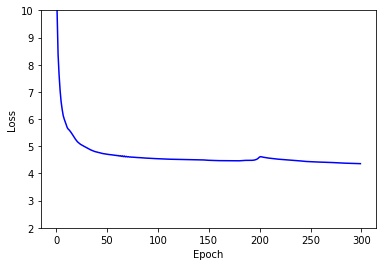

In [53]:
loss2 = history4.history['loss']
epochs2 = range(len(loss2))
plt.plot(epochs2, loss2, 'b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([2,10])
plt.show()

* Prediction with LSTM model.
* Prediction around the high peaks is better using LSTM than simple RNN. Also the shift observed for simple RNN prediction is gone.

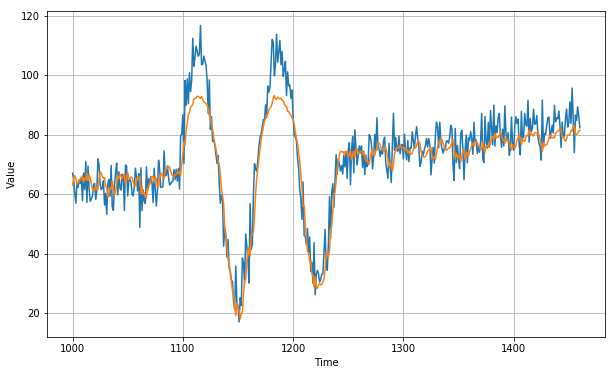

In [54]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model4.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results2 = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results2)
plt.show()

* LSTM predicts much lower error than simple RNN.
* The long memory of LSTM model has a good impact on forecasting this time series.

In [56]:
print("LSTM MSE = ", keras.metrics.mean_squared_error(x_valid, results2).numpy())
print("LSTM MAE = ", keras.metrics.mean_absolute_error(x_valid, results2).numpy())

LSTM MSE =  51.287094
LSTM MAE =  5.513144
